In [1]:
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import Tensor
import torch
from torch.optim import Adam

# Models
First let's define our models, and the baseline model (ModelReLU). The latter will be used to compare our model in the defined task.

In [2]:
from localized_look.model import LoLoLayer

class ModelLoLo(nn.Module):
    def __init__(self, activation="invsquare"):
        super().__init__()
        self.layer = nn.Sequential(
            LoLoLayer(n_kernels=100, n_channels=2, fusion="channels", activation=activation),
            nn.LeakyReLU(.05),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layer(x)

class ModelReLU(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(2, 26),
            nn.LeakyReLU(.05),
            nn.Linear(26, 26),
            nn.LeakyReLU(.05),
            nn.Linear(26, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layer(x)

In [3]:
model_lolo = ModelLoLo()
model_relu = ModelReLU()

In [4]:
model_lolo

ModelLoLo(
  (layer): Sequential(
    (0): LoLoLayer(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=1, out_features=100, bias=True)
          (1): LoLoInvSquare()
        )
        (1): Sequential(
          (0): Linear(in_features=1, out_features=100, bias=True)
          (1): LoLoInvSquare()
        )
      )
      (fusion_layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=2, out_features=1, bias=True)
        )
        (1): Sequential(
          (0): Linear(in_features=2, out_features=1, bias=True)
        )
        (2): Sequential(
          (0): Linear(in_features=2, out_features=1, bias=True)
        )
        (3): Sequential(
          (0): Linear(in_features=2, out_features=1, bias=True)
        )
        (4): Sequential(
          (0): Linear(in_features=2, out_features=1, bias=True)
        )
        (5): Sequential(
          (0): Linear(in_features=2, out_features=1, bias=True)
        )
        (6): Sequ

In [5]:
model_relu

ModelReLU(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=26, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=26, out_features=26, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=26, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

# Benchmark
Our dataset will be a "checkerboard" like, i.e., with sparse locals where the label is one. The net figure is a visualization of this. There is 2 features (X and Y).

In [19]:
from torch.utils.data import DataLoader, Dataset
from localized_look.utils import create_labels_checker


class dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
#         self.w = w
        assert len(x) == len(y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]#, self.w[i]


x = np.random.rand(5000, 2)*24-12
y = create_labels_checker(x, 5, size=1.2, stride=5, start=-10)
x_true, y_true = x.copy(), y.copy()

x, y = torch.Tensor(x), torch.Tensor(y)

trainloader = torch.utils.data.DataLoader(
    dataset(x, y),
    batch_size=64,
    shuffle=True,
    num_workers=0
)

Just checking that all models are comparable in the number of parameters (the ReLU model has 6 more parameters).

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("LoLo model n parameters:", count_parameters(model_lolo))
print("ReLU model n parameters:", count_parameters(model_relu))

LoLo model n parameters: 801
ReLU model n parameters: 807


This is our training data. We can see that the label (Z axis) is 1 in specific points of the dataset.

Text(0.5, 0, 'Label')

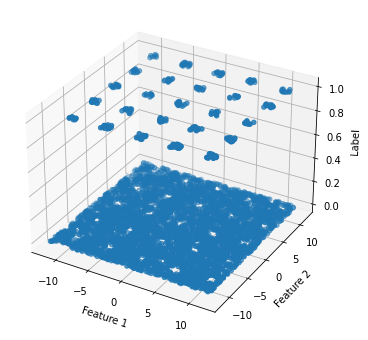

In [21]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:, 0], x[:, 1], y)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Label')

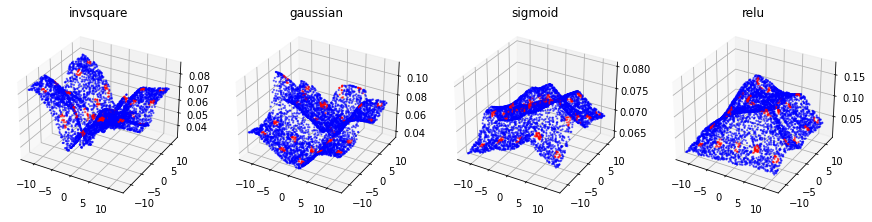

Epoch 0 :
invsquare loss:0.258, Mean batch time: 36.637ms
gaussian loss:0.248, Mean batch time: 36.851ms
sigmoid loss:0.306, Mean batch time: 37.208ms
relu loss:0.337, Mean batch time: 1.759ms


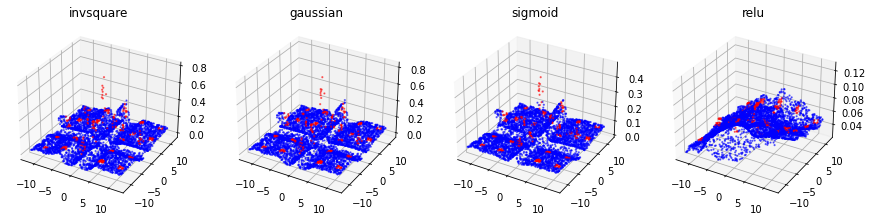

Epoch 30 :
invsquare loss:0.194, Mean batch time: 44.378ms
gaussian loss:0.197, Mean batch time: 44.733ms
sigmoid loss:0.218, Mean batch time: 44.732ms
relu loss:0.232, Mean batch time: 2.466ms


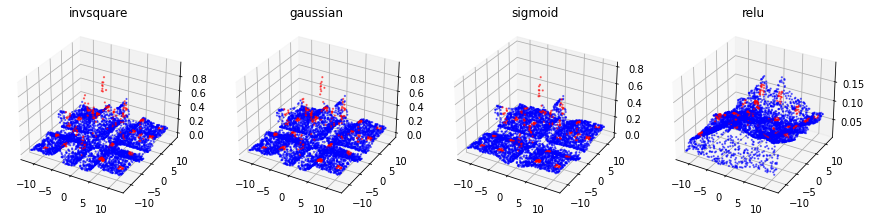

Epoch 60 :
invsquare loss:0.180, Mean batch time: 42.413ms
gaussian loss:0.185, Mean batch time: 42.729ms
sigmoid loss:0.204, Mean batch time: 42.733ms
relu loss:0.227, Mean batch time: 2.125ms


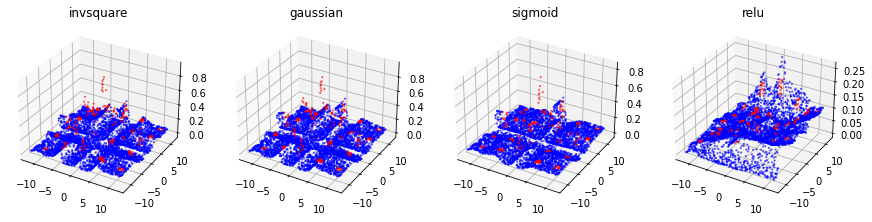

Epoch 90 :
invsquare loss:0.171, Mean batch time: 41.590ms
gaussian loss:0.176, Mean batch time: 41.902ms
sigmoid loss:0.198, Mean batch time: 41.928ms
relu loss:0.220, Mean batch time: 2.105ms


In [ ]:
from localized_look.utils import weight_init
import time

activations = ["invsquare", "gaussian", "sigmoid"]

models = {act:ModelLoLo(activation=act) for act in activations}
models.update(
    {
        "relu": ModelReLU()
    }
)

for model in models.values():
    model.apply(weight_init)
    model.train()

optimizers = {model_key:Adam(models[model_key].parameters(), lr=1e-3) for model_key in models}

loss_fn = nn.BCELoss()

times = {model_key:[] for model_key in models}
for epoch in range(210):
    losses = {model_key:[] for model_key in models}
    for x, y in trainloader:
        for optim in optimizers.values():
            optim.zero_grad()
        # ModelLoLo
        for model_key in models:
            start_time = time.time()
            pred = models[model_key].forward(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizers[model_key].step()
            losses[model_key] += [loss.item()]
            end_time = time.time()
            delta = end_time - start_time
            times[model_key] += [delta]
    # Calculate mean time using the last 5 epochs
    times[model_key] =  times[model_key][-len(trainloader)*5:]
    if epoch % 30 == 0:
        
        x, y = x_true, y_true

        fig = plt.figure(figsize=(15, 6))
        axes = [fig.add_subplot(100 + len(models)*10 + i + 1, projection='3d') for i in range(len(models))]
        for i, model_key in enumerate(models):
            pred = models[model_key].forward(torch.Tensor(x_true)).detach().numpy()
            axes[i].scatter(x[:, 0], x[:, 1], pred, c=y, alpha=.5, s=1.5, cmap="bwr")
            axes[i].set_title(model_key)
        plt.show()
        print("Epoch", epoch, ":")
        for model_key in models:
            print(
                "{} loss:{:.3f}, Mean batch time: {:.3f}ms".format(
                    model_key,
                    np.mean(losses[model_key]),
                    np.mean(times[model_key])*1000,
                )
            )

In [ ]:
# x_ = np.linspace(-1, 1, 1000).reshape(-1, 1)
x_ = np.concatenate([np.linspace(-2, 2, 100).reshape(-1, 1), np.linspace(-2, 2, 100).reshape(-1, 1)], axis=1)
x = torch.Tensor(x_)
m = list(model.layer.children())[0]
pred = m(x).detach()
# plt.plot(x_, pred)
# plt.show()
plt.plot(x_, model.forward(torch.Tensor(x_)).detach())
# plt.show()
# plt.plot(x_true, y_true)


In [ ]:
x= np.linspace(-3, 3, 1000)
mu, std = 0, 1
y1 = (1/(np.pi*(2*std)**.5))*np.exp(-.5*(x-mu)**2/std)
y2 = 1/(x**2 + 1)/5
plt.plot(x, y1)
plt.plot(x, y2)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# x = np.random.rand(1000, 2)
# a, b = x.T
# y = ((a < .4) & ( a > .1) &  (b < .9) & ( b > .5)) | ((a > .7) & ( a < .9) &  (b > .1) & ( b < .6))
x, y = x_true, y_true
pred = model.forward(torch.Tensor(x)).detach().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(x[:, 0], x[:, 1], y, c=(pred>.5).astype(int).flatten())
ax.scatter(x[:, 0], x[:, 1], pred, c=y)
# ax.scatter(x[:, 0], x[:, 1], (pred>.2).astype(int).flatten(), c=y)


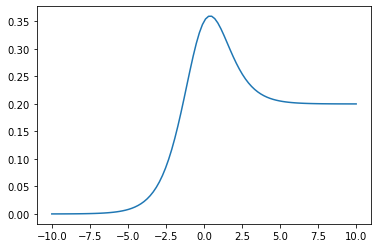

In [935]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

x = np.linspace(-10, 10, 100)
y = sigmoid(x)*(1.2-sigmoid(x))
plt.plot(x, y)